# DSCI 100 Group 20 Project Final Report

Participants: 

- Hannah Yin 
- Dan Choi
- (Absent)
- (Absent)

## 1.0 Introduction

Minecraft is an open-world sandbox game where players can freely build, explore, communicate, and form a metaverse within a virtual space. **The Pacific Laboratory for Artificial Intelligence, led by Professor Frank Wood and based in the Department of Computer Science at the University of British Columbia**, launched a data collection project called plaicraft.ai on September 27, 2023. plaicraft.ai focuses on collecting players' behaviour, such as gameplay, speech, and key presses, to train AI that can react not only to text messages but also to complex situations surrounding them.

To contribute to the research project, we have chosen one of the three broad questions provided to us: **"We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts."** This question is vital for scientists to ask, as marketing this project to the targeted audience can increase both the efficiency of recruiting efforts and the quality of the data collected. 

For our DSCI 100 project, we have formulated the specific predictive question: **"Can a player's total played hours and age predict if they are subscribed to a game-related newsletter?"** We will answer our target question using one of the datasets provided to us: player.csv.


### 1.1 About the Data

In [24]:
# Let us load packages that we will use in this project. 
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

In [25]:
# First, let us load our dataset.
players <- read_csv("https://raw.githubusercontent.com/ahnnahy/dsci100-group20-project/refs/heads/main/players%20(1).csv")

# We will show the first 5 rows of the dataset as a reference and for visualization.
head(players,5)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21


Our dataset has 196 rows and 7 columns, for a total of 1372 observations.

The players data set shown above shows statistics on the types of players that have played on the PLAIcraft Minecraft server.

We have 7 different variables in the original dataset:
- `experience` - a character variable describing whether the player is a beginner, amateur, regular, pro, or veteran
- `subscribe` - a logical (true/false) variable that tells us if the player is subscribed to a game-related newsletter
- `hashedEmail` - a character variable of the player's email, hashed to ensure that their information is safe
- `played_hours` - a double variable of the total hours the player has played on the server
- `name` - character variable of the player's name
- `gender` - character variable of the player's gender
- `Age` - a double variable of the player's age

This data, collected from https://plaicraft.ai/, may have potential issues with variables such as `name`, `experience`, `age`, and `gender`, which are self-reported by players. These variables reported by the players can be easily faked; for example, younger players will likely enter an earlier birthday so their parents do not have to sign a consent form for them.

### 1.2 Wrangling Data for KNN classification

Since we will be visualizing the data and performing KNN classification on the dataset, we will change the `subscribe` column's data type from a logical variable to a factor variable. Since TRUE means that the player is subscribed and FALSE means thay they are not subscribed, we can rename those variables so that they are easier to interpret in our visualizations. Finally, we noticed that in the player.csv file, one of the ages is NA. Since we do not have enough knowledge to replace it with a certain age, we will just use drop_na to remove that row.

In [36]:
#Wrangling data as mentioned above.
players <- players |>
    mutate(subscribe = as_factor(subscribe))  |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not subscribed" = "FALSE")) |>
    drop_na(subscribe) 
# head(players,6)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `subscribe = fct_recode(subscribe, Subscribed = "TRUE", `Not
  subscribed` = "FALSE")`.
Caused by warning:
! Unknown levels in `f`: TRUE, FALSE”


In [38]:
# Check that this was successful
str(players$subscribe)

 Factor w/ 2 levels "Not subscribed",..: 2 2 1 2 2 2 2 1 2 2 ...


Note that despite the error message, we were still successful in converting the subscribe variables into factors and changing their names.

## 2.0 Methods

### 2.1 Distribution of Data

Warning message in geom_histogram(stat = "count", fill = "grey50"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


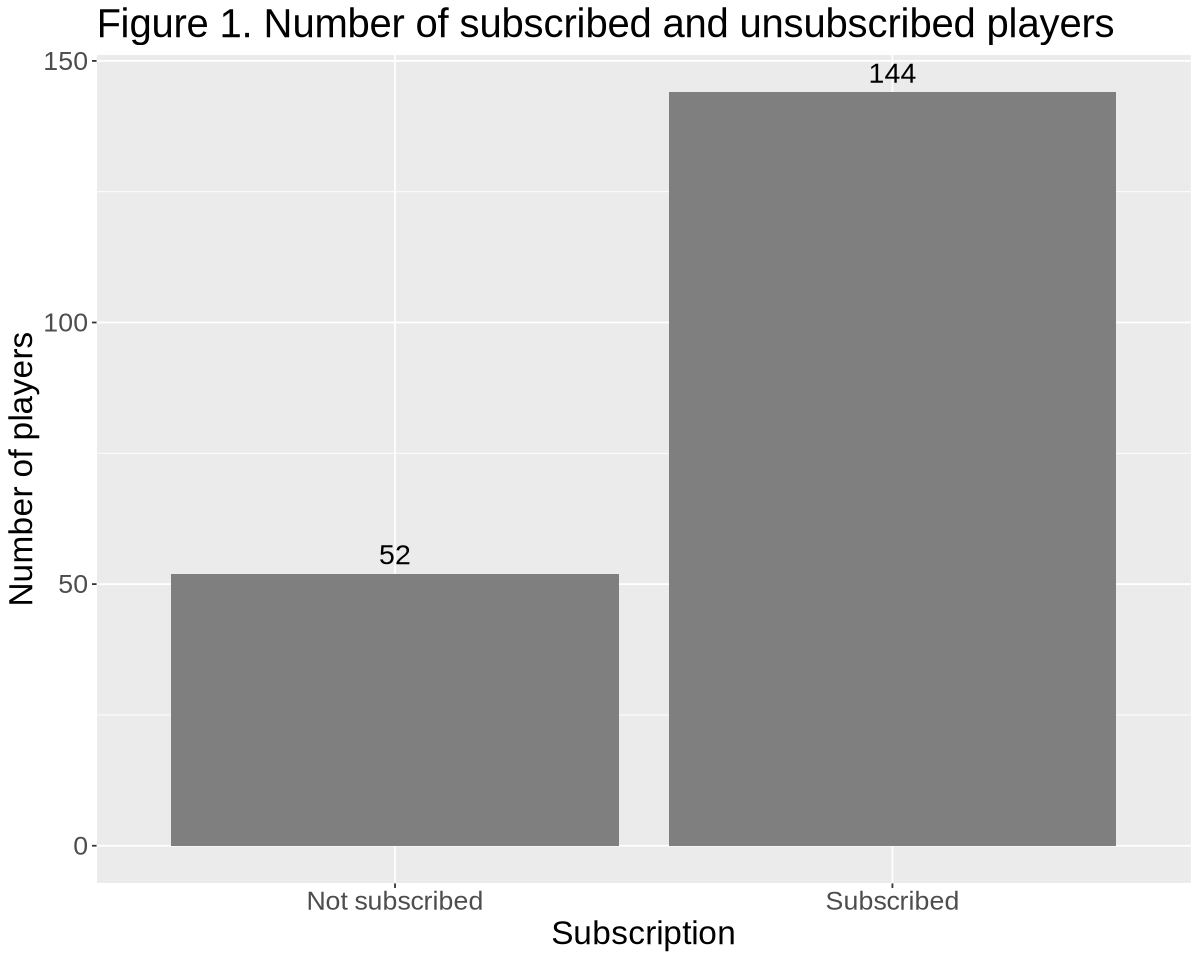

In [39]:
# Let us visualize the distribution of subscribed users and unsuscribed users.
options(repr.plot.width = 10, repr.plot.height = 8)

players_histogram <- ggplot(players, aes(x = subscribe)) +
    geom_histogram(stat = "count", fill = "grey50") +
    geom_text(stat = "count", aes(label = ..count..), vjust = -0.5, size = 6) +
    labs(x = "Subscription", y = "Number of players", title = "Figure 1. Number of subscribed and unsubscribed players") +
    theme(text = element_text(size = 20))

players_histogram

It was found in `Figure 1.` that the number of subscribed and unsubscribed users has a significant difference, where there are almost 3 times more subscribed plauyers than unsubscribed players.

### Method to address our question

To address our question, we will use **KNN classification** with nearest neighbours to predict a player's subscription status based on total hours spent on the server and age. To apply this method, we will assume that the player's age was reported honestly and accurately. Potential limitations include insufficient data points to make accurate predictions and an uneven distribution of subscribed and unsubscribed players. We will split the data into a training set (75%) and a test set (25%), then use 5-fold cross-validation to find the best number of nearest neighbours and evaluate the model's accuracy on the test set.



Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


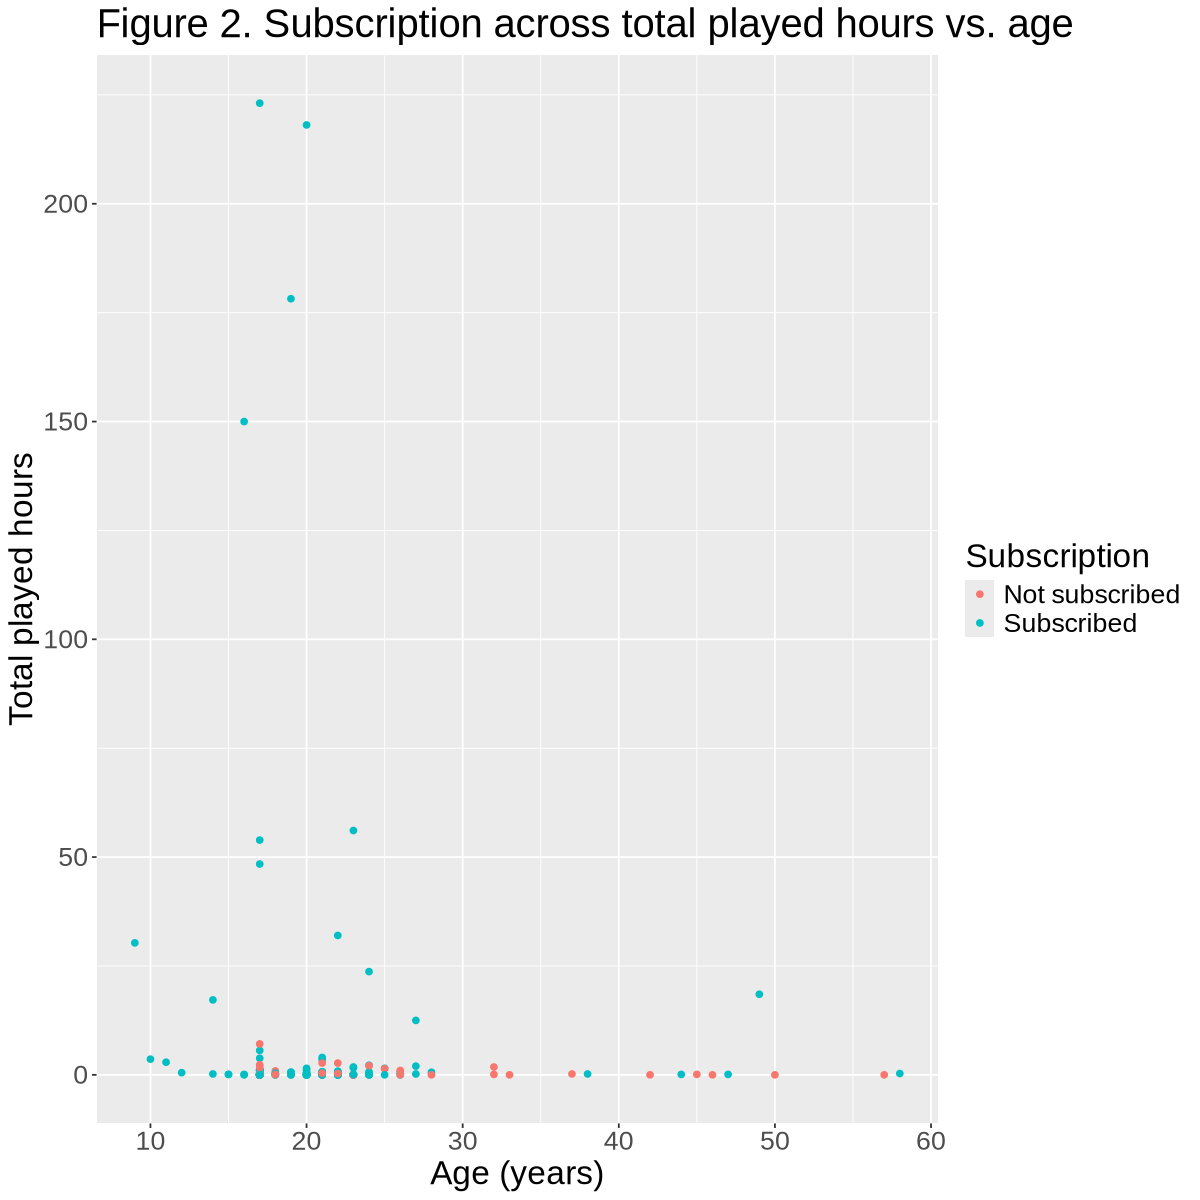

In [40]:
#Let us make a graph to visualize the subscription status in relation to age and total played hours.
options(repr.plot.width = 10, repr.plot.height = 10)

players_plot <- ggplot(players, aes(x = Age, y = played_hours, colour = subscribe)) +
    geom_point() +
    labs(x = "Age (years)", y = "Total played hours", color = "Subscription", title = "Figure 2. Subscription across total played hours vs. age") +
    theme(text = element_text(size = 20))

players_plot

Looking at the scatter plot above, there may be a correlation between total played hours and subscription, but there does not seem to be one between age and subscription. To reach an accurate conclusion, we need many more data points on the graph.

In [42]:
str(players$subscribe)

 Factor w/ 2 levels "Not subscribed",..: 2 2 1 2 2 2 2 1 2 2 ...


In [43]:
set.seed(100)

players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- player_results |>
  filter(.metric == "accuracy")

accuracies


→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5302340,4,0.06290010,Preprocessor1_Model001
2,accuracy,binary,0.5213054,4,0.05981932,Preprocessor1_Model002
3,accuracy,binary,0.6507184,4,0.03746696,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,accuracy,binary,0.7352011,4,0.005388091,Preprocessor1_Model098
99,accuracy,binary,0.7352011,4,0.005388091,Preprocessor1_Model099
100,accuracy,binary,0.7352011,4,0.005388091,Preprocessor1_Model100


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.7438218,4,0.014998376,Preprocessor1_Model019
21,accuracy,binary,0.7435345,4,0.009386118,Preprocessor1_Model021
22,accuracy,binary,0.7435345,4,0.009386118,Preprocessor1_Model022
23,accuracy,binary,0.7435345,4,0.009386118,Preprocessor1_Model023
24,accuracy,binary,0.7435345,4,0.009386118,Preprocessor1_Model024


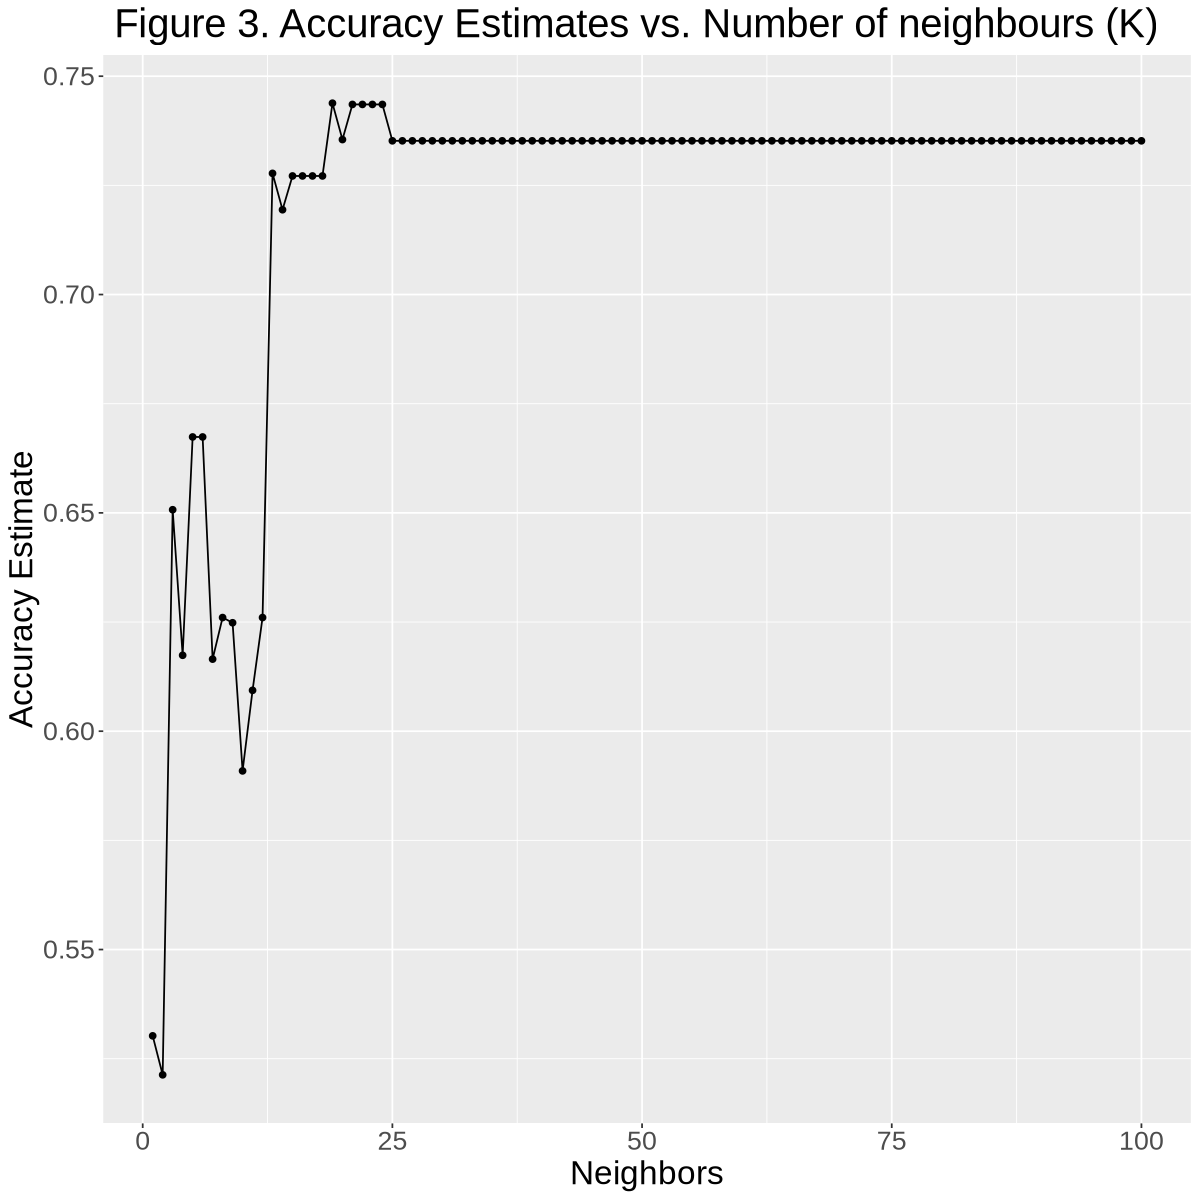

In [44]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = " Figure 3. Accuracy Estimates vs. Number of neighbours (K)") +
  theme(text = element_text(size = 20)) 

best_k <- accuracies |>
    slice_max(mean, n = 5)

accuracy_vs_k
best_k

We can see above that the best there are two k values with the same accuracy estimate. Since we already do not have many data points to begin with, to avoid overfitting, we will pick K = 19 to run on our cross-validation and test on the testing set. However, we can see in the table above the graph that K = 19, K = 23, K = 25, and K = 26, all have very similar means (accuracy estimates), and using any one of them would probably yield similar results.

In [45]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

player_best_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_best_spec) |>
  fit(data=players_train)

player_test_predictions <- predict(player_best_results, players_test) |>
  bind_cols(players_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 48) to match `..2` (size 49).


## 3.0 Discussion

We have found that the model accurately predicts whether the player is subscribed with approximately 71.43% accuracy. For a dataset like this, it is a reasonable value, but it is too low for one that could have serious consequences if it predicts incorrectly. This accuracy estimate may not be accurate due to the significant difference between the number of subscribers and the number of unsubscribers. The closest points to the point we want to predict are often subscribed rather than unsubscribed, because there are many more subscribed players than unsubscribed players in the dataset. We had expected the classifier to be neither very strong nor very weak, so this is similar to what we expected. We can correctly answer our predictive question if we build the classifier on a larger training set that has roughly equal numbers of each of the possible categories we want to predict. This can absolutely lead to further questions, such as whether other predictors would be more useful than age and total played hours, and whether there is a definite correlation between subscription and any of our predictors.

## 4.0 References

“Pacific Laboratory for Artificial Intelligence.” Pacific Laboratory for Artificial Intelligence, 11 Sept. 2025, plai.cs.ubc.ca/. 

PLAI. “Plaicraft.” PLAICraft, 2025 Pacific Laboratory of Artificial Intelligence, www.plaicraft.ai/. Accessed 6 Dec. 2025. 

“Plaicraft.Ai Launch.” Pacific Laboratory for Artificial Intelligence, 21 Jan. 2025, plai.cs.ubc.ca/2023/09/27/plaicraft/. 